In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

In [2]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles_register.csv")
metadata_df = pd.read_csv("/net/scratch/jmoehring/metadata_manual_with_resolution.csv")

In [3]:
# transform center_lat and center_lon to EPSG:4326 if crs is not EPSG:4326
def transform_coordinates(row):
    if row["crs"] != "EPSG:4326":
        transformer = Transformer.from_crs(row["crs"], "EPSG:4326", always_xy=True)
        return pd.Series(transformer.transform(row["center_lon"], row["center_lat"]))
    else:
        return pd.Series([row["center_lon"], row["center_lat"]])

In [4]:
# add column with EPSG:4326 lat and long of the center of the image. If the image is not in EPSG:4326, the center of the image is calculated in the original projection
metadata_df["center_lat"] = (metadata_df["north"] + metadata_df["south"]) / 2
metadata_df["center_lon"] = (metadata_df["east"] + metadata_df["west"]) / 2

# apply transforma_coordinates to the metadata_df
metadata_df[["center_lon", "center_lat"]] = metadata_df.apply(transform_coordinates, axis=1)

In [5]:
# load shapefile as geopandas dataframe
ecoregion_gdf = gpd.read_file("/net/scratch/jmoehring/wwf_terr_ecos.shp")

In [6]:
ecoregion_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14458 entries, 0 to 14457
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    14458 non-null  int64   
 1   AREA        14458 non-null  float64 
 2   PERIMETER   14458 non-null  float64 
 3   ECO_NAME    14458 non-null  object  
 4   REALM       14363 non-null  object  
 5   BIOME       14458 non-null  float64 
 6   ECO_NUM     14458 non-null  float64 
 7   ECO_ID      14458 non-null  float64 
 8   ECO_SYM     14458 non-null  float64 
 9   GBL_STAT    14458 non-null  float64 
 10  G200_REGIO  6924 non-null   object  
 11  G200_NUM    14458 non-null  float64 
 12  G200_BIOME  14458 non-null  float64 
 13  G200_STAT   14458 non-null  float64 
 14  Shape_Leng  14458 non-null  float64 
 15  Shape_Area  14458 non-null  float64 
 16  area_km2    14458 non-null  int64   
 17  eco_code    14458 non-null  object  
 18  PER_area    14458 non-null  float64 
 

In [7]:
# find corresponding ecoregion for each image and add the biome value as new column
def find_ecoregion(row):
    point = Point(row["center_lon"], row["center_lat"])
    ecoregions = ecoregion_gdf[ecoregion_gdf.geometry.contains(point)]
    if len(ecoregions) == 1:
        return ecoregions["BIOME"].iloc[0]
    else:
        raise ValueError(f"Point {point} is in {len(ecoregions)} ecoregions")

In [8]:
metadata_df["biome"] = metadata_df.apply(find_ecoregion, axis=1)

<Axes: >

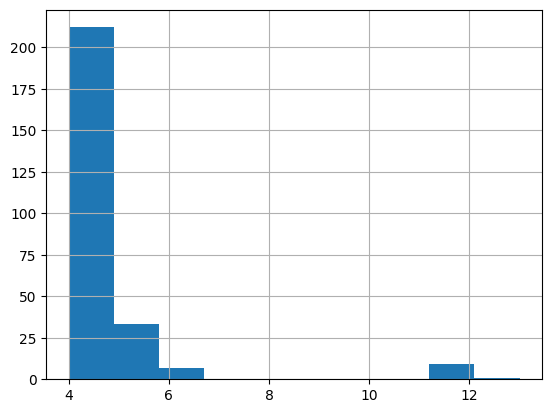

In [9]:
metadata_df["biome"].hist()

In [10]:
# export center lat long and biome to geopackage in EPSG:4326
metadata_gdf = gpd.GeoDataFrame(metadata_df, geometry=gpd.points_from_xy(x=metadata_df["center_lon"], y=metadata_df["center_lat"]), crs="EPSG:4326")

# save to geopackage
metadata_gdf.to_file("/net/scratch/jmoehring/metadata_biome.gpkg", driver="GPKG")

In [37]:
# add biome column to register_df joined on the filename
register_df = register_df.merge(right=metadata_df[["filename", "biome"]], left_on="base_file_name", right_on="filename").drop(columns="filename")

In [ ]:
# save to csv
register_df.to_csv("/net/scratch/jmoehring/tiles_register_biome.csv", index=False)